# Coordinate Descent for LASSO
-  Recall that we can use the coordinate descent algorithm to solve the Lasso problem:

$$\beta_j \leftarrow \mathbf{S}(\sum_{i}x_{ij}(y_i-\tilde{y}_i^{(j)}),\lambda)$$

where $\mathbf{S}(b,\lambda)=sign(b)(|b|-\lambda)_{+}$ and $\tilde{y}_i^{(j)}=\sum_{k\neq j}x_{ik}\beta_k$.

In [1]:
################################# Lasso solver using CD without active set ####################################
LassoSolver2 <- function(X,y,lam,Xvar,beta_old,tol,maxIter){
  n  <- nrow(X)
  p  <- ncol(X)
  
  betat <- beta_old
  yhat <- X%*%betat
  obj <- rep(0,maxIter)
  obj[1] <-  evalObj(y,yhat,betat,lam)
  
  for(iter in 2:maxIter){
    for(j in 1:p){
      betat[j] <- t(X[,j]) %*% (y-yhat) + Xvar[j]*beta_old[j] 
      betat[j] <- softThresh(betat[j],lam) / Xvar[j]
      diff_beta <- beta_old[j] - betat[j]
      
      if(abs(diff_beta)>0){
        yhat <- yhat - X[,j]*diff_beta
        beta_old[j] <- betat[j]
      }
    }
    obj[iter] <- evalObj(y,yhat,betat,lam)
    if(abs(obj[iter]-obj[iter-1])<tol){
      obj <- obj[1:iter]
      break
    }
  }
  cat(" Finished!\t",iter-1," loops\n")
  out <- list(betat = betat, obj=obj)
}

## Active set 
- After a cycle through p variables, we can restrict further iterations to the __active set__ till convergence

In [2]:
############################################# Lasso solver using CD with active set #########################################
LassoSolver1 <- function(X,y,lam,Xvar,beta_old,mm,m,nin,tol,maxIter){
  n  <- nrow(X)
  p  <- ncol(X)
  
  betat <- beta_old
  yhat <- X%*%betat
  obj_outer <- rep(0,maxIter)
  obj_outer[1] <-  evalObj(y,yhat,betat,lam)
  total_inner <- 0
  
  for(iter_outer in 2:maxIter){
    for(j in 1:p){
      betat[j] <- t(X[,j]) %*% (y-yhat) + Xvar[j]*beta_old[j]
      betat[j] <- softThresh(betat[j],lam) / Xvar[j]
      diff_beta <- beta_old[j] - betat[j]
      
      if(abs(diff_beta)>0){
        yhat <- yhat - X[,j]*diff_beta
        beta_old[j] <- betat[j]
        if(mm[j]==0){
          nin <- nin+1
          mm[j] <- nin
          m[nin] <- j
        }
      }
    }
    obj_outer[iter_outer] <- evalObj(y,yhat,betat,lam)
    if(abs(obj_outer[iter_outer]-obj_outer[iter_outer-1])<tol){
      obj_outer <- obj_outer[1:iter_outer]
      break
    }
    
    # inner loop for active set
    obj_inner <- rep(0,maxIter)
    obj_inner[1] <-  evalObj(y,yhat,betat,lam)
    for(iter_inner in 2:maxIter){
      total_inner <- total_inner + 1
      for(k in 1:nin){
        j <- m[k]
        
        betat[j] <- t(X[,j]) %*% (y-yhat) + Xvar[j]*beta_old[j]
        betat[j] <- softThresh(betat[j],lam) / Xvar[j]
        diff_beta <- beta_old[j] - betat[j]
        if(abs(diff_beta)>0){
          yhat <- yhat - X[,j]*diff_beta
          beta_old[j] <- betat[j]
        }
      }
      obj_inner[iter_inner] <- evalObj(y,yhat,betat,lam)
      if(abs(obj_inner[iter_inner]-obj_inner[iter_inner-1])<tol) break
    }
  }
  cat(" Finished!\t",iter_outer-1," outer loops;\t",total_inner," inner loops\n")
  out <- list(betat = betat, mm=mm, m=m, nin=nin, obj=obj_outer)
}

## Gradient descent
- proximal gradient descent for non-differentible, convex problem
- accelerated gradient method with momentum update

In [3]:

#################################### Lasso solver using GD ###########################################
LassoSolver3 <- function(X,y,lam,s,betat,tol,maxIter){
  n  <- nrow(X)
  p  <- ncol(X)
  
  yhat <- X%*%betat
  obj <- rep(0,maxIter)
  obj[1] <-  evalObj(y,yhat,betat,lam)
  
  for(iter in 2:maxIter){
    betat <- betat - s * t(X) %*% (yhat-y) 
    betat <- sapply(betat,softThresh,lam=s*lam)#softThresh(betat,s*lam)
    yhat <- X%*%betat
    
    obj[iter] <- evalObj(y,yhat,betat,lam)
    # cat(iter-1," loops: obj = ",obj[iter],"\n")
    if(abs(obj[iter]-obj[iter-1])<tol){
      obj <- obj[1:iter]
      break
    }
  }
  cat(" Finished!\t",iter-1," loops\n")
  out <- list(betat = betat, obj=obj)
}


######################################### Lasso solver using accelerated GD with momentum ##################################
LassoSolver4 <- function(X,y,lam,s,beta_old,tol,maxIter){
  n  <- nrow(X)
  p  <- ncol(X)
  
  thetat <- betat <- beta_old
  yhat <- X%*%betat
  obj <- rep(0,maxIter)
  obj[1] <-  evalObj(y,yhat,betat,lam)
  
  for(iter in 2:maxIter){
    betat <- thetat - s * t(X) %*% (yhat-y) 
    betat <- sapply(betat,softThresh,lam=s*lam)#softThresh(betat,s*lam)
    thetat <- betat + (iter-1)/(iter+2) * (betat-beta_old)
    yhat <- X%*%betat
    beta_old <- betat
    
    obj[iter] <- evalObj(y,yhat,betat,lam)
    # cat(iter-1," loops: obj = ",obj[iter],"\n")
    if(abs(obj[iter]-obj[iter-1])<tol){
      obj <- obj[1:iter]
      break
    }
  }
  cat(" Finished!\t",iter-1," loops\n")
  out <- list(betat = betat, obj=obj)
}



In [4]:
# Lasso regression. Both X and y are not scaled/centerized
Lasso <- function(X, y, lambda=NULL, s=NULL, center = T, scale = T, tol=1e-8, maxIter=1000, method="ACD") {
  
  n  <- nrow(X)
  p  <- ncol(X)
  # ns <- length(lambda)
  
  #Check standardization consistency 
  if(!center & scale){
    warning("Centering is required when 'scale' is TRUE. 'center' is automatically set to be TRUE.")
    center <- TRUE
  }
  
  #Centering, Scaling or do nothing
  if(center){
    # beta <- matrix(0,p,ns)
    ym <- mean(y)
    y  <- y-ym
    Xm <- colMeans(X)
    X <- scale(X,center = T,scale = F)
    if(scale){
      Xsd <- sqrt(colMeans(X^2))
      X <- apply(X,MARGIN = 1,function(X,sd) X/sd,sd=Xsd)
      X <- t(X)
    }
  }
  
  #default lambda setting
  if(is.null(lambda)) {
    XX <- t(X)%*%X
    #pre-calculate eigenvalues and eigenvectors
    eigenXX <- eigen(XX)
    D <- eigenXX$values
    U <- eigenXX$vectors
    loglam <- seq(5*log10(max(D)),-0.5*log10(max(D)),length.out = 100)
    lambda <- exp(loglam)
  }
  
  ns <- length(lambda)
  beta <- matrix(0,p,ns)    # solution path for beta
  beta0 <- rep(0,ns)        # solution path for beta0/intercept
  betat <- rep(0,p)         # initialize beta by zero
  obj <- vector("list",ns)
  
  # using gradient descent
  if(method=="GD" | method=="AGD"){
    if(is.null(s)){
      XX <- t(X)%*%X
      eigenXX <- eigen(XX)
      s <- 1/max(eigenXX$values)
    }
    for(i_lam in 1:ns){
      if(method=="GD"){
        fit <- LassoSolver3(X,y,lambda[i_lam],s,betat,tol,maxIter) 
      } else if(method=="AGD"){
        fit <- LassoSolver4(X,y,lambda[i_lam],s,betat,tol,maxIter) 
      }
      betat <- fit$betat
      obj[[i_lam]] <- fit$obj
      
      #Recover the intercept
      if(scale){
        beta0[i_lam] <- ym - t(Xm/Xsd)%*%fit$betat
        beta[,i_lam] <- fit$betat/Xsd
      } else if(center){
        beta0[i_lam] <- ym - Xm%*%fit$betat
        beta[,i_lam] <- fit$betat
      } else{
        beta0[i_lam] <- ym
        beta[,i_lam] <- fit$betat
      }
    }
    
  }
  
  # using coordinate descent
  if(method=="ACD" | method=="CD"){
    Xvar <- colSums(X^2)
    
    if(method=="ACD"){
      mm <- rep(0,p)    # record whether the variable in the active set
      m <- rep(0,p)     # record active variables
      nin <- 0          # initialize the number of all zeros
    }
    
    #Fit the path
    for(i_lam in 1:ns){
      if(method=="ACD"){
        fit <- LassoSolver1(X,y,lambda[i_lam],Xvar,betat,mm,m,nin,tol,maxIter)
        mm <- fit$mm
        m <- fit$m
        nin <- fit$nin
      } else if(method=="CD"){
        fit <- LassoSolver2(X,y,lambda[i_lam],Xvar,betat,tol,maxIter)
      }
      
      betat <- fit$betat
      obj[[i_lam]] <- fit$obj
      
      #Recover the intercept
      if(scale){
        beta0[i_lam] <- ym - t(Xm/Xsd)%*%fit$betat
        beta[,i_lam] <- fit$betat/Xsd
      } else if(center){
        beta0[i_lam] <- ym - Xm%*%fit$betat
        beta[,i_lam] <- fit$betat
      } else{
        beta0[i_lam] <- ym
        beta[,i_lam] <- fit$betat
      }
    }
  }
  
  beta <- list(beta=beta,beta0=beta0,obj=obj,lambda=lambda)
  attr(beta, "class") <- "Lasso"
  return(beta)
}

###################################################### Soft Threshold function ######################################################
softThresh <- function(b,lam){
  out <- max(0,b-lam) - max(0,-b-lam)
  out
}

###################################################### evaluate objective function ######################################################
evalObj <- function(y,yhat,betat,lam){
  # 1 / (2 * nobs) RSS + lambda * penalty
  n <- length(y)
  out <- 0.5 * sum((y-yhat)^2) + lam*sum(abs(betat))
  out
}

In [5]:
library(glmnet)
# source("/Users/canyang/Documents/github_Yang/statistical-learning/Statistical-Machine-Learning/Lasso.R")
# set.seed(10)
ntrain <- 100
p <- 1000
c0 <- 2
xtrain <- 2*matrix(rnorm(ntrain*p),ntrain,p) + c0
xtrain[,1] <- xtrain[,1] * 3

b <- rep(0,p)
b[1:10] <- rnorm(10)

b0 <- 1
ytrain <- xtrain%*%b + b0 + rnorm(ntrain,0,sqrt(var(xtrain%*%b)))#rnorm(ntrain,0,1)

# centerize xtrain
cc <- colMeans(xtrain)
xtrain2 <- t(t(xtrain) - cc)

# standardize xtrain?
standardizeX <- T

if(standardizeX){
  s <- sqrt(colMeans(xtrain2^2))
  xtrain2 <- t(t(xtrain2)/s)
}

# get lambda sequence
MaxLam <- max(abs(t(xtrain2)%*%ytrain))
loglam <- seq(log10(MaxLam),log10(0.2*MaxLam),length.out = 100)
# loglam <- seq(2*log10(p^2),-log10(p^2),length.out = 100)
lam <- 10^(loglam)#exp(loglam)



Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [6]:
# fit using glmnet
fitglmnet <- glmnet(xtrain,ytrain,alpha=1,lambda = lam/ntrain,standardize = T,thresh = 1e-10)

In [7]:
fitLasso1 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam,method="ACD")

 Finished!	 1  outer loops;	 0  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  

In [8]:
fitLasso2 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam,method="CD")

 Finished!	 1  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 2  loops
 Finished!	 3  loops
 Finished!	 4  loops
 Finished!	 5  loops
 Finished!	 5  loops
 Finished!	 5  loops
 Finished!	 5  loops
 Finished!	 5  loops
 Finished!	 5  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 6  loops
 Finished!	 7  loops
 Finished!	 7  loops
 Finished!	 7  loops
 Finished!	 7  loops
 Finished!	 7  loops
 Finished!	 7

In [9]:
fitLasso3 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam,method="GD")

 Finished!	 1  loops
 Finished!	 122  loops
 Finished!	 122  loops
 Finished!	 121  loops
 Finished!	 121  loops
 Finished!	 121  loops
 Finished!	 121  loops
 Finished!	 120  loops
 Finished!	 120  loops
 Finished!	 120  loops
 Finished!	 120  loops
 Finished!	 119  loops
 Finished!	 119  loops
 Finished!	 119  loops
 Finished!	 118  loops
 Finished!	 118  loops
 Finished!	 118  loops
 Finished!	 118  loops
 Finished!	 117  loops
 Finished!	 117  loops
 Finished!	 117  loops
 Finished!	 117  loops
 Finished!	 116  loops
 Finished!	 116  loops
 Finished!	 116  loops
 Finished!	 116  loops
 Finished!	 115  loops
 Finished!	 118  loops
 Finished!	 133  loops
 Finished!	 139  loops
 Finished!	 118  loops
 Finished!	 117  loops
 Finished!	 117  loops
 Finished!	 116  loops
 Finished!	 116  loops
 Finished!	 130  loops
 Finished!	 102  loops
 Finished!	 102  loops
 Finished!	 102  loops
 Finished!	 101  loops
 Finished!	 101  loops
 Finished!	 100  loops
 Finished!	 133  loops
 Finished!	 1

In [10]:
fitLasso4 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam,method="AGD")

 Finished!	 1  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 153  loops
 Finished!	 108  loops
 Finished!	 325  loops
 Finished!	 214  loops
 Finished!	 171  loops
 Finished!	 171  loops
 Finished!	 171  loops
 Finished!	 171  loops
 Finished!	 182  loops
 Finished!	 104  loops
 Finished!	 275  loops
 Finished!	 275  loops
 Finished!	 275  loops
 Finished!	 275  loops
 Finished!	 275  loops
 Finished!	 89  loops
 Finished!	 148  loops
 Finished!	 24

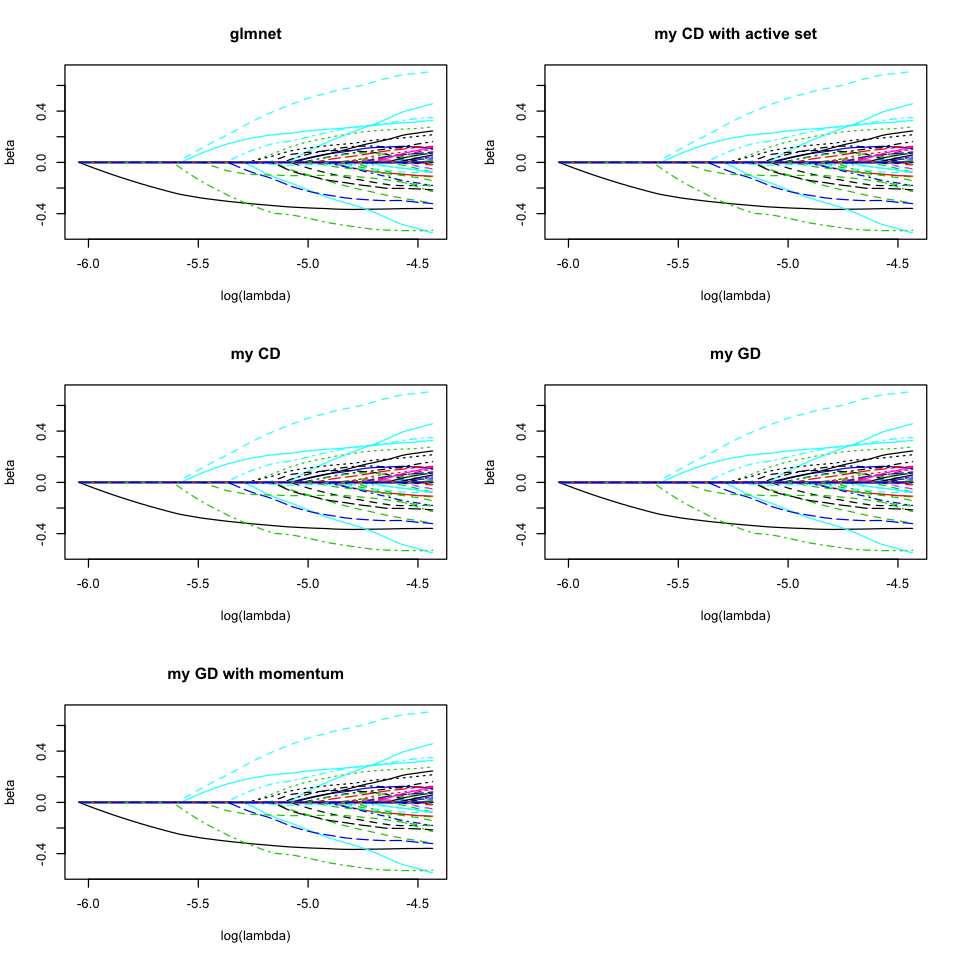

In [11]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(3,2))
# matplot(-log(lam),t(fitglmnet$beta),pch=20)
# matplot(-log(lam),t(fitLasso$beta),pch=20)
matplot(-log(lam),t(fitglmnet$beta),type="l",xlab="log(lambda)",ylab="beta",main="glmnet")
matplot(-log(lam),t(fitLasso1$beta),type="l",xlab="log(lambda)",ylab="beta",main="my CD with active set")
matplot(-log(lam),t(fitLasso2$beta),type="l",xlab="log(lambda)",ylab="beta",main="my CD")
matplot(-log(lam),t(fitLasso3$beta),type="l",xlab="log(lambda)",ylab="beta",main="my GD")
matplot(-log(lam),t(fitLasso4$beta),type="l",xlab="log(lambda)",ylab="beta",main="my GD with momentum")

In [12]:
rm(list=ls())
source("/Users/cmx/Desktop/PRML practice/Lasso/Lasso.R")

n_rep <- 10

err <- vector("list",4)
err[[1]] <- err[[2]] <- err[[3]] <- err[[4]] <- vector("list",10)



for(i in 1:n_rep){
  ntrain <- 100
  p <- 1000
  c0 <- 2
  # xtrain <- matrix(rnorm(ntrain*p),ntrain,p)
  xtrain <- 2*matrix(rnorm(ntrain*p),ntrain,p) + c0
  xtrain[,1] <- xtrain[,1] * 3
  
  b <- rep(0,p)
  b[1:10] <- rnorm(10)
  
  b0 <- 1
  ytrain <- xtrain%*%b + b0 + rnorm(ntrain,0,sqrt(9*var(xtrain%*%b)))
  
  # centerize xtrain
  cc <- colMeans(xtrain)
  xtrain2 <- t(t(xtrain) - cc)
  
  # standardize xtrain?
  standardizeX <- T
  
  if(standardizeX){
    s <- sqrt(colMeans(xtrain2^2))
    xtrain2 <- t(t(xtrain2)/s)
  }
  
  # get lambda sequence
  MaxLam <- max(abs(t(xtrain2)%*%ytrain))
  loglam <- seq(log10(MaxLam),log10(0.2*MaxLam),length.out = 100)
  # loglam <- seq(2*log10(p^2),-log10(p^2),length.out = 100)
  lam <- 10^(loglam)#exp(loglam)
  
  fitLasso1 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam[50],method="ACD")
  fitLasso2 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam[50],method="CD")
  fitLasso3 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam[50],method="GD")
  fitLasso4 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam[50],method="AGD")
  
  # err[[1]][[i]] <- log(fitLasso1$obj[[1]]-tail(fitLasso1$obj[[1]],1))
  # err[[2]][[i]] <- log(fitLasso2$obj[[1]]-tail(fitLasso2$obj[[1]],1))
  # err[[3]][[i]] <- log(fitLasso3$obj[[1]]-tail(fitLasso3$obj[[1]],1))
  # err[[4]][[i]] <- log(fitLasso4$obj[[1]]-tail(fitLasso4$obj[[1]],1))
  
  err[[1]][[i]] <- (fitLasso1$obj[[1]]-tail(fitLasso1$obj[[1]],1))/tail(fitLasso1$obj[[1]],1)
  err[[2]][[i]] <- (fitLasso2$obj[[1]]-tail(fitLasso2$obj[[1]],1))/tail(fitLasso2$obj[[1]],1)
  err[[3]][[i]] <- (fitLasso3$obj[[1]]-tail(fitLasso3$obj[[1]],1))/tail(fitLasso3$obj[[1]],1)
  err[[4]][[i]] <- (fitLasso4$obj[[1]]-tail(fitLasso4$obj[[1]],1))/tail(fitLasso4$obj[[1]],1)
}



 Finished!	 4  outer loops;	 37  inner loops
 Finished!	 22  loops
 Finished!	 686  loops
 Finished!	 999  loops
 Finished!	 4  outer loops;	 39  inner loops
 Finished!	 23  loops
 Finished!	 633  loops
 Finished!	 999  loops
 Finished!	 4  outer loops;	 34  inner loops
 Finished!	 21  loops
 Finished!	 629  loops
 Finished!	 999  loops
 Finished!	 5  outer loops;	 44  inner loops
 Finished!	 20  loops
 Finished!	 546  loops
 Finished!	 999  loops
 Finished!	 4  outer loops;	 73  inner loops
 Finished!	 43  loops
 Finished!	 999  loops
 Finished!	 999  loops
 Finished!	 4  outer loops;	 27  inner loops
 Finished!	 15  loops
 Finished!	 377  loops
 Finished!	 965  loops
 Finished!	 4  outer loops;	 33  inner loops
 Finished!	 20  loops
 Finished!	 558  loops
 Finished!	 999  loops
 Finished!	 5  outer loops;	 35  inner loops
 Finished!	 15  loops
 Finished!	 428  loops
 Finished!	 999  loops
 Finished!	 4  outer loops;	 28  inner loops
 Finished!	 16  loops
 Finished!	 460  loops
 Finis

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 541 rows containing missing values (geom_path).”

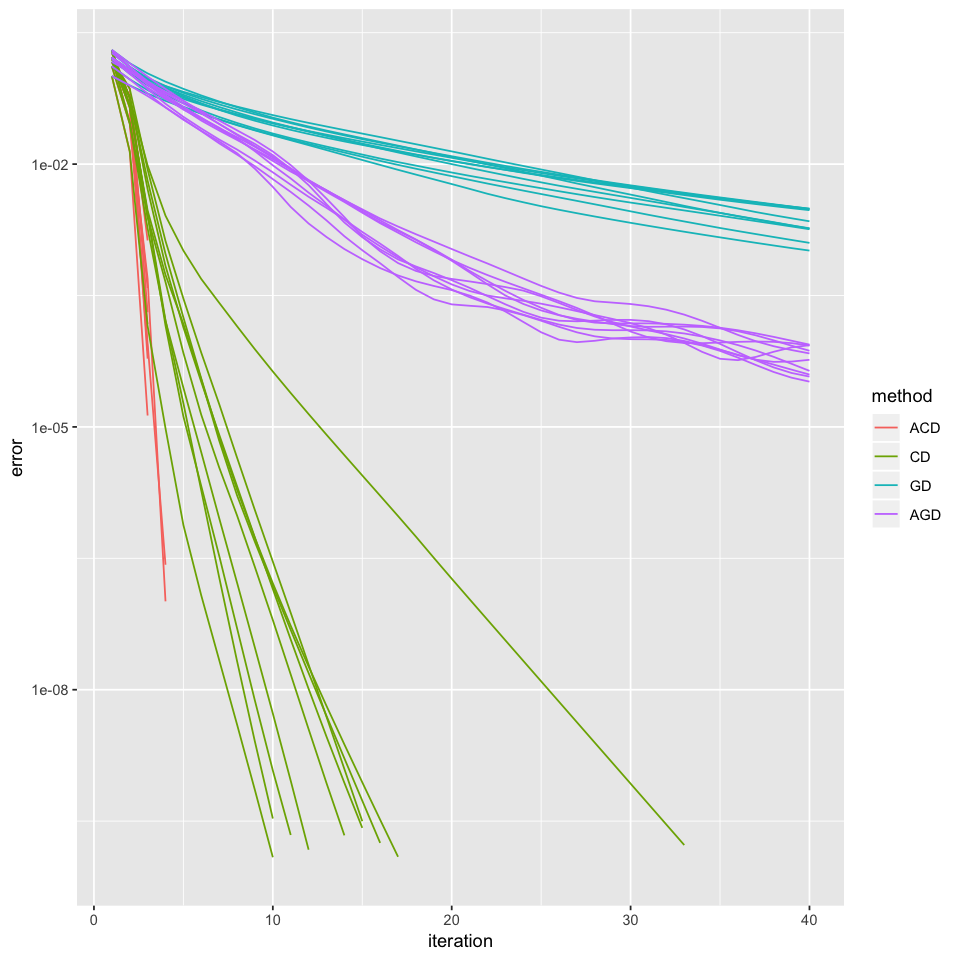

In [13]:
library(ggplot2)
cutoff <- 40
method <- c("ACD","CD","GD","AGD")
out <- data.frame()

i_line <- 0
for(k in 1:4){
  for(i in 1:n_rep){
    i_line <- i_line + 1
    out <- rbind(out,data.frame((err[[k]][[i]][1:cutoff]),1:cutoff,method[k],i_line),row.names=NULL)
  }
}
out <- do.call(data.frame,lapply(out, function(x) replace(x, is.infinite(x),NA)))
names(out) <- c("error","iteration","method","line")
ggplot(out,aes(y=error,x=iteration,color=method,group=line)) +
  geom_line() + scale_y_log10(limits=c(1e-10,NA))